In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

### 1: Load the Cleaned Dataset

This dataset is already preprocessed:

    One-hot encoding is done.
    
    Timestamp column is removed.
    
    HighRiskDepression (target) is present.

In [6]:
# 1. Load final preprocessed dataset
df = pd.read_csv("smmh_final_preprocessed.csv")
df['HighRiskDepression'] = (df['18. How often do you feel depressed or down?'] >= 4).astype(int)

### 2: Define Features and Target

X contains input features (age, usage patterns, comparisons, etc.)

y is the target label: 1 = high-risk, 0 = low-risk

In [11]:
X = df.drop(columns=["18. How often do you feel depressed or down?", "HighRiskDepression"])
y = df["HighRiskDepression"]

### 3: Split Data into Training and Test Sets

    80% data used to train the models (X_train, y_train)
    
    20% reserved for testing (X_test, y_test)
    
    stratify=y: keeps the same 0/1 ratio in both sets

In [15]:
# 2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### 4: Preprocessing (Standard Scaling)

Applies standard scaling to all features (mean=0, std=1)

Scaling helps models like SVM and KNN perform better

In [19]:
# 3. Preprocessing (standard scaling only)
preprocessor = ColumnTransformer([
    ("scale", StandardScaler(), X.columns.tolist())
])

### 5: Build a Flexible Pipeline

  - Pipeline structure:
    
    - Preprocess the input (StandardScaler)
        
    - Apply a classifier (clf)
    
   - We’ll swap in different models later

In [23]:
# 4. Base pipeline
pipe = Pipeline([
    ("pre", preprocessor),
    ("clf", LogisticRegression())  # placeholder
])

### 6: Define 6 Popular ML Models and Their Hyperparameters

We try 6 models with various tuning options:

1. Logistic Regression

2. Random Forest

3. Gradient Boosting

4. Support Vector Machine (SVM)

5. K-Nearest Neighbors (KNN)

6. XGBoost

Each model has a hyperparameter grid (like learning rate, depth, etc.)

In [27]:
# 5. Model + parameter search space
param_distributions = [
    {
        "clf": [LogisticRegression(max_iter=1000, random_state=42)],
        "clf__C": np.logspace(-3, 3, 7),
    },
    {
        "clf": [RandomForestClassifier(random_state=42)],
        "clf__n_estimators": [100, 200, 500],
        "clf__max_depth": [None, 10, 20]
    },
    {
        "clf": [GradientBoostingClassifier(random_state=42)],
        "clf__n_estimators": [100, 200, 500],
        "clf__learning_rate": [0.01, 0.1, 0.2],
        "clf__max_depth": [3, 5, 7]
    },
    {
        "clf": [SVC(probability=True, random_state=42)],
        "clf__C": [0.1, 1, 10],
        "clf__kernel": ["linear", "rbf"],
        "clf__gamma": ["scale", "auto"]
    },
    {
        "clf": [KNeighborsClassifier()],
        "clf__n_neighbors": [3, 5, 7],
        "clf__weights": ["uniform", "distance"]
    },
    {
        "clf": [XGBClassifier(random_state=42, n_jobs=1, eval_metric="logloss", verbosity=0)],
        "clf__n_estimators": [100, 200],
        "clf__learning_rate": [0.01, 0.1],
        "clf__max_depth": [3, 5],
        "clf__subsample": [0.8, 1.0],
        "clf__colsample_bytree": [0.8, 1.0]
    }
]

### 7: Find the Best Model Using RandomizedSearchCV

    Randomly tests 50 combinations from all models

    Performs 5-fold cross-validation

    Picks the model with the best average accuracy

In [31]:
# 6. Perform RandomizedSearchCV
search = RandomizedSearchCV(
    pipe,
    param_distributions,
    n_iter=50,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    random_state=42,
    verbose=2,
    error_score=np.nan
)
search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('pre',
                                              ColumnTransformer(transformers=[('scale',
                                                                               StandardScaler(),
                                                                               ['1. '
                                                                                'What '
                                                                                'is '
                                                                                'your '
                                                                                'age?',
                                                                                '2. '
                                                                                'Gender',
                                                                                '6. '
                                                                                'Do '
                                                                                'you '
                                                                                'use '
                                                                                'social '
                                                                                'media?',
                                                                                '8. '
                                                                                'What '
                                                                                'is '
                                                                                'the '
                                                                                'average '
                                                                                'time '
                                                                                'you '
                                                                                'spend '
                                                                                'on '
                                                                                'social '
                                                                                'media '
                                                                                'every '
                                                                                'day?',
                                                                                '9. '
                                                                                'How '
                                                                                'often '
                                                                                'do '
                                                                                'you '
                                                                                'find '
                                                                                'yourself '
                                                                                'using '
                                                                                'Social '
                                                                                'media '
                                                                                'without '
                                                                                'a '
                                                                                'spec...
                                                               max_depth=None,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                              

### 8: Print Best Model and Its Accuracy

Tells us which model performed the best during training

In [34]:
# 7. Best model from all search
print("Best model found:", type(search.best_estimator_.named_steps['clf']).__name__)
print("Best CV accuracy :", round(search.best_score_, 4))

Best model found: SVC
Best CV accuracy : 0.5381


### 9: Retune Top 3 Models Individually

We manually retune:

Random Forest

Gradient Boosting

SVM

Why? Because we want to use them in an ensemble next

In [37]:
# 8. Build an ensemble using top 3 models manually
# Re-tune top 3 models separately using best param search (you can skip retuning if satisfied with the first results)

# Define individual tuned pipelines again
best_models = {
    "RandomForest": RandomizedSearchCV(
        Pipeline([("pre", preprocessor), ("clf", RandomForestClassifier(random_state=42))]),
        {
            'clf__n_estimators': [100, 200],
            'clf__max_depth': [None, 10, 20],
            'clf__min_samples_split': [2, 5]
        },
        n_iter=5, cv=5, scoring='accuracy', random_state=42, n_jobs=-1
    ),
    "GradientBoosting": RandomizedSearchCV(
        Pipeline([("pre", preprocessor), ("clf", GradientBoostingClassifier(random_state=42))]),
        {
            'clf__n_estimators': [100, 200],
            'clf__learning_rate': [0.01, 0.1],
            'clf__max_depth': [3, 5]
        },
        n_iter=5, cv=5, scoring='accuracy', random_state=42, n_jobs=-1
    ),
    "SVM": RandomizedSearchCV(
        Pipeline([("pre", preprocessor), ("clf", SVC(probability=True, random_state=42))]),
        {
            'clf__C': [0.1, 1],
            'clf__kernel': ['rbf', 'linear'],
            'clf__gamma': ['scale', 'auto']
        },
        n_iter=5, cv=5, scoring='accuracy', random_state=42, n_jobs=-1
    )
}

In [38]:
# 9. Fit each model
for model_name, model_cv in best_models.items():
    model_cv.fit(X_train, y_train)
    print(f"{model_name} tuned & trained.")

RandomForest tuned & trained.
GradientBoosting tuned & trained.
SVM tuned & trained.


### 10: Train a Soft-Voting Classifier (Ensemble)

    Combines the top 3 models
    
    Each model predicts probabilities, and we average them
    
    Improves robustness and generalization

In [41]:
# 10. Create Voting Ensemble
voting = VotingClassifier(estimators=[
    ('rf', best_models["RandomForest"].best_estimator_),
    ('gb', best_models["GradientBoosting"].best_estimator_),
    ('svc', best_models["SVM"].best_estimator_)
], voting='soft', n_jobs=-1)
voting.fit(X_train, y_train)


VotingClassifier(estimators=[('rf',
                              Pipeline(steps=[('pre',
                                               ColumnTransformer(transformers=[('scale',
                                                                                StandardScaler(),
                                                                                ['1. '
                                                                                 'What '
                                                                                 'is '
                                                                                 'your '
                                                                                 'age?',
                                                                                 '2. '
                                                                                 'Gender',
                                                                                 '6. '
                                                                                 'Do '
                                                                                 'you '
                                                                                 'use '
                                                                                 'social '
                                                                                 'media?',
                                                                                 '8. '
                                                                                 'What '
                                                                                 'is '
                                                                                 'the '
                                                                                 'average '
                                                                                 'time '
                                                                                 'you '
                                                                                 'spend '
                                                                                 'on '
                                                                                 'social '
                                                                                 'media '
                                                                                 'every '
                                                                                 'day?',
                                                                                 '9. '
                                                                                 'How '
                                                                                 'often '
                                                                                 'do '
                                                                                 'you '
                                                                                 'find '
                                                                                 'yourself '
                                                                                 'using '
                                                                                 'Social '
                                                                                 'media '
                                                                                 'without '
                                                                                 'a '
                                                                                 'spe...
                                                                                 'Occupation '
                                                                                 'Status_School '
                                                              

### 11: Evaluate All Models on Test Set

We check how each model performs on unseen test data

Models evaluated:

Random Forest (tuned)

Gradient Boosting (tuned)

SVM (tuned)

Voting Ensemble (combined)

In [44]:
# 11. Evaluate All Models
models = {
    'Random Forest (tuned)': best_models["RandomForest"].best_estimator_,
    'Gradient Boosting (tuned)': best_models["GradientBoosting"].best_estimator_,
    'SVM (tuned)': best_models["SVM"].best_estimator_,
    'Voting Ensemble': voting
}

accuracies = {name: accuracy_score(y_test, model.predict(X_test)) for name, model in models.items()}
acc_df = pd.DataFrame.from_dict(accuracies, orient='index', columns=['Accuracy'])

### 12: Display Accuracy Scores

Shows side-by-side comparison of test accuracy for all models

Helps us clearly see which model performed best

In [47]:
# 12. Show results
print("\n Model Accuracies on Test Set:")
print(acc_df)


 Model Accuracies on Test Set:
                           Accuracy
Random Forest (tuned)      0.505400
Gradient Boosting (tuned)  0.529158
SVM (tuned)                0.537797
Voting Ensemble            0.520518


### 13: Visualize with a Bar Chart

Final comparison plot

Easy to communicate results visually in your report or presentation

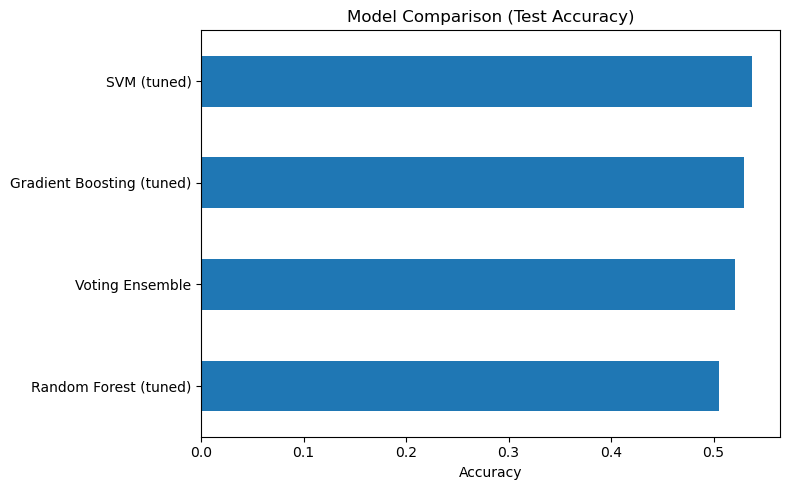

In [50]:
# 13. Plot
acc_df.sort_values("Accuracy").plot(kind="barh", legend=False, figsize=(8, 5))
plt.title("Model Comparison (Test Accuracy)")
plt.xlabel("Accuracy")
plt.tight_layout()
plt.show()

In [53]:
import joblib
joblib.dump(best_models["SVM"].best_estimator_, "best_model.pkl")

['best_model.pkl']